### Initial setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
# Read data
data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
# Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values #Y because no missing values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

### REGRESSION MODEL

### Strategy by distribution imputation

In [5]:
# Mask missing values

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(Y_syn)
Y_syn_train = np.ma.masked_array(Y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(Y_nnf)
Y_nnf_train = np.ma.masked_array(Y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(Y_dnt)
Y_dnt_train = np.ma.masked_array(Y_dnt, mask=y_dnt_missing)

### Define and fit the model

In [6]:
with pm.Model() as model_hierar:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [7]:
# ## Define BDNF
with model_hierar:
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sd=Xsigma_bdnf, 
                                         observed=X_bdnf_train)    

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [8]:
# ## Define SYN
with model_hierar:
    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p = lp_syn, observed=Y_syn_train)

In [9]:
# ## Define NNF
with model_hierar:
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [10]:
# ## Define DNT
with model_hierar:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [11]:
# ## Checking the proposed structure of model
model_hierar.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                  -13.82
beta_syn                    -4.61
beta_nnf                    -6.91
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
y_obs_syn_missing            0.00
Xmu_nnf                     -2.76
Xsigma_nnf_log__            -2.31
X_nnf_modelled_missing       0.00
y_obs_nnf_missing            0.00
X_bdnf_modelled           -865.53
y_obs_bdnf                 -67.24
X_syn_modelled            -295.25
y_obs_syn                  -67.24
X_nnf_modelled            -452.70
y_obs_nnf                  -67.24
y_obs_dnt                  -67.24
Name: Log-probability of test_point, dtype: float64

In [12]:
# ## Run inferences
with model_hierar:
    trace_hierar = pm.sample(cores=4, nuts ={'target_accept':0.90})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing, y_obs_syn_missing, y_obs_nnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


In [13]:
# ## Run inferences and return inferences for convergences
with model_hierar:
    trace_hierar_p = pm.sample(cores=4, return_inferencedata=True, nuts ={'target_accept':0.90})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing, y_obs_syn_missing, y_obs_nnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


In [14]:
# ## Compute posterior distributions
with model_hierar:
    posterior_hierar = pm.sample_posterior_predictive(trace_hierar)

In [15]:
# ## Convert and store in Arviz format
idata_hierar = az.from_pymc3(trace=trace_hierar, 
                             posterior_predictive=posterior_hierar,
                             model=model_hierar)
idata_hierar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

### Check convergences

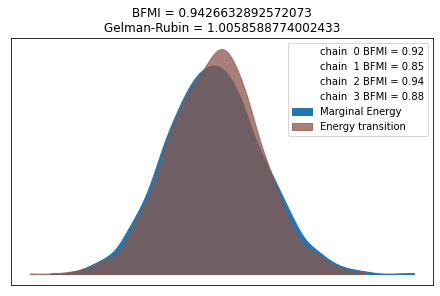

In [16]:
# Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace_hierar))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace_hierar).values()).values
(pm.energyplot(trace_hierar, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

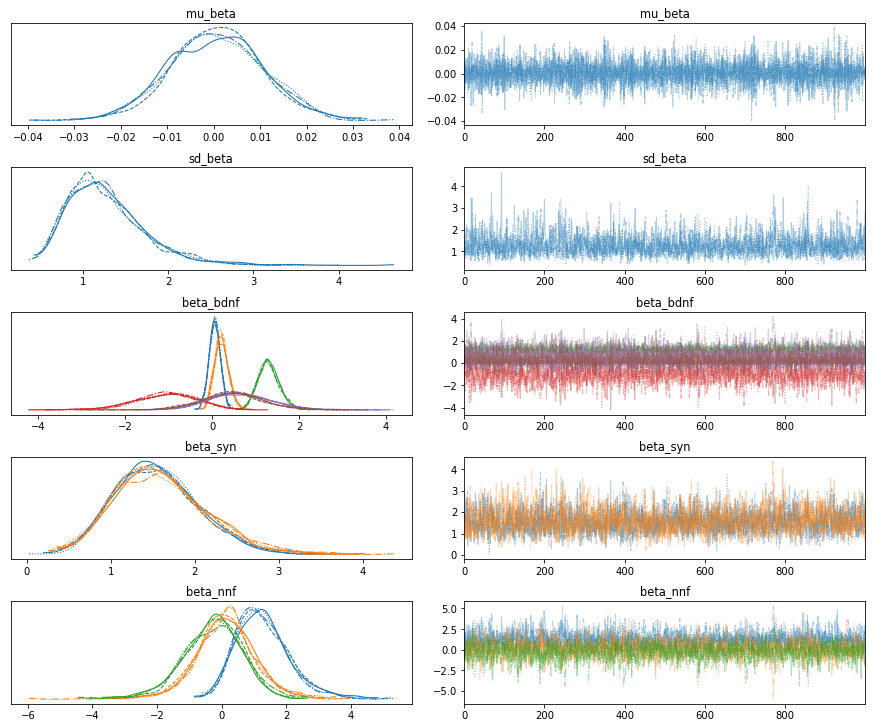

In [17]:
# Check hyperpriors and priors
pm.traceplot(trace_hierar, var_names=['mu_beta', 'sd_beta', 'beta_bdnf', 'beta_syn', 'beta_nnf']);

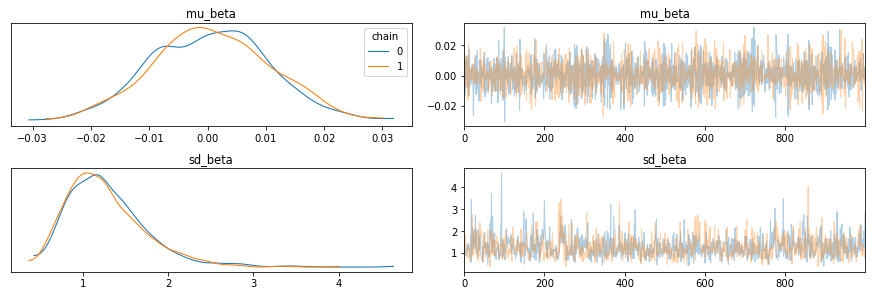

In [18]:
# Check convergence for hyperpriors of two chains
az.plot_trace(trace_hierar, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

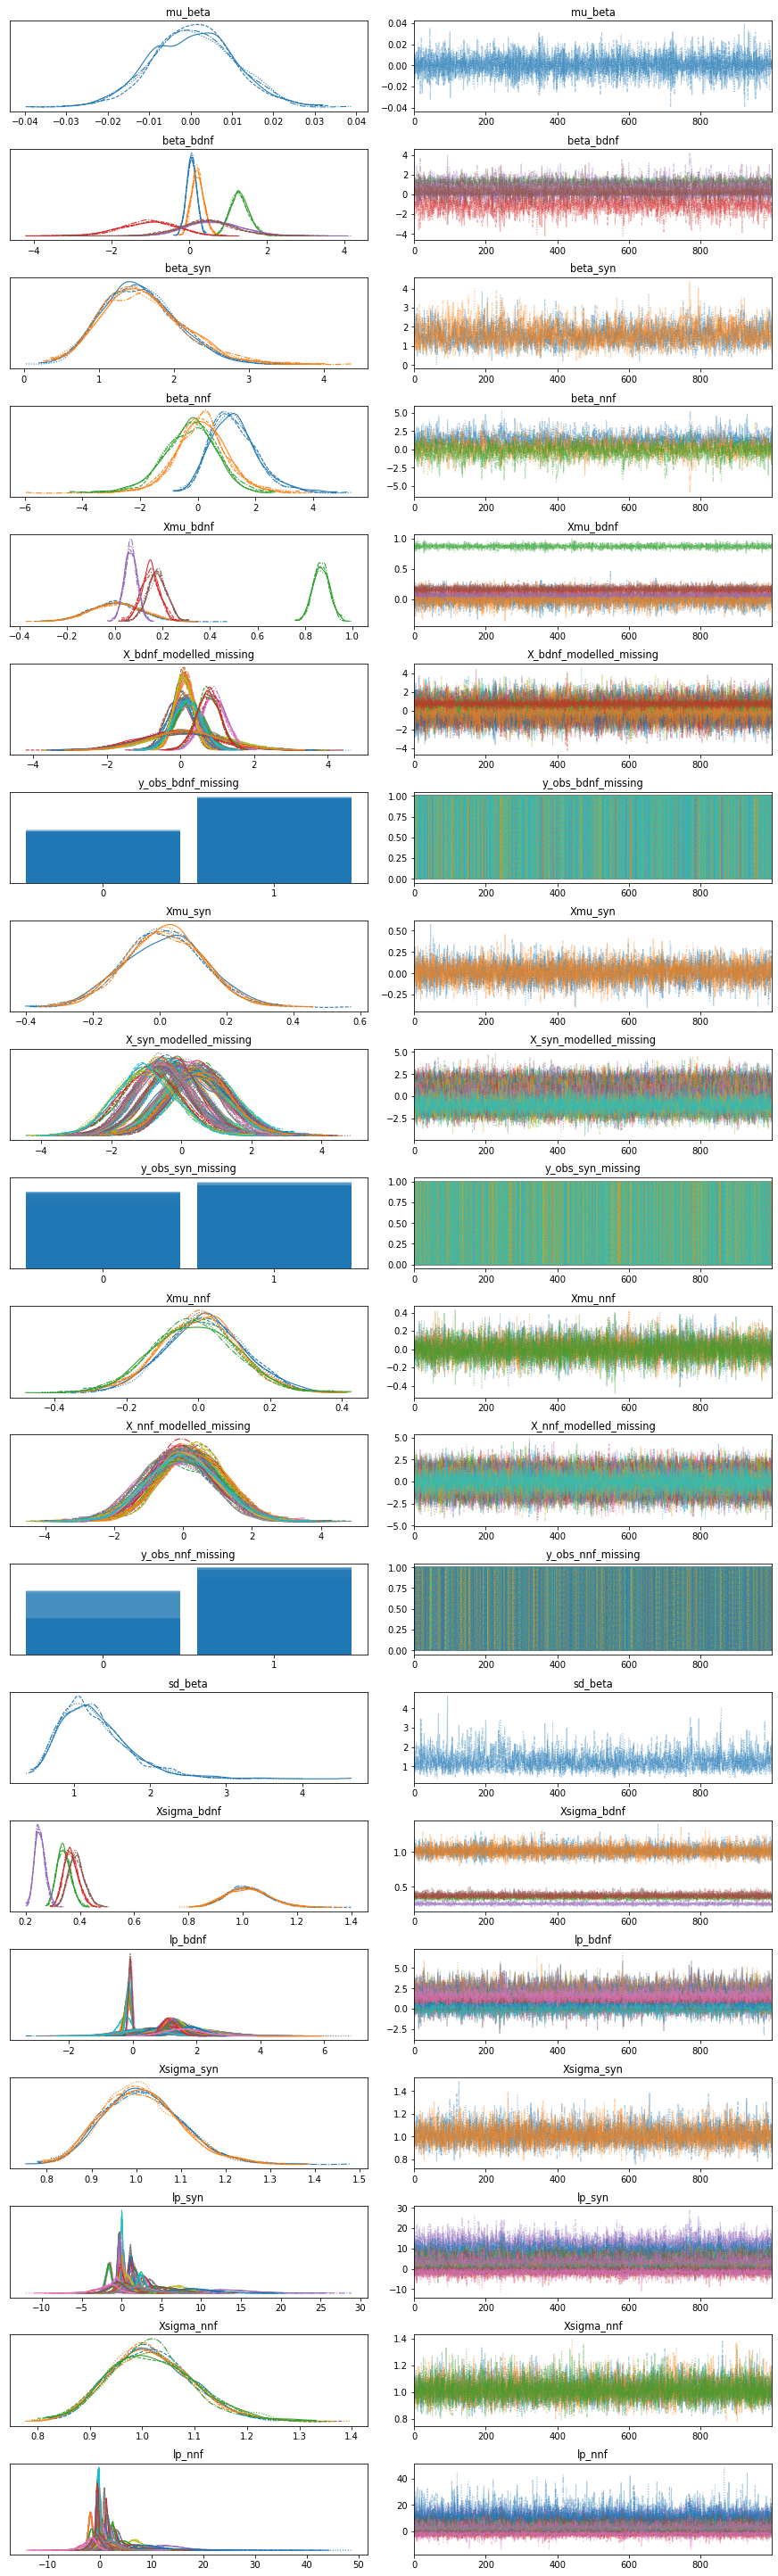

In [19]:
# For publication
# Plot traces of all variables
pm.traceplot(trace_hierar);

In [20]:
# Statistical summary
stats = az.summary(trace_hierar, round_to=None)
stats
#Save the statistical summary of the trace
#file = az.summary(trace_hierar, round_to=None)
#file.to_csv('Statistical_summary_trace.csv')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_beta         0.001  0.010  -0.019    0.018      0.000    0.000    9288.0   
beta_bdnf[0,0]  0.060  0.129  -0.182    0.310      0.002    0.002    4599.0   
beta_bdnf[1,0]  0.217  0.160  -0.090    0.509      0.002    0.002    4173.0   
beta_bdnf[2,0]  1.300  0.245   0.855    1.770      0.006    0.004    1553.0   
beta_bdnf[3,0] -1.058  0.722  -2.333    0.332      0.017    0.012    1759.0   
...               ...    ...     ...      ...        ...      ...       ...   
lp_dnt[92,0]    0.110  1.991  -3.791    3.763      0.036    0.027    3130.0   
lp_dnt[93,0]   -2.716  2.849  -8.169    1.960      0.051    0.039    3137.0   
lp_dnt[94,0]   -0.017  2.031  -3.528    4.135      0.035    0.030    3374.0   
lp_dnt[95,0]    0.016  2.041  -3.811    3.987      0.037    0.029    3010.0   
lp_dnt[96,0]   -2.172  2.759  -7.604    2.547      0.050    0.038    3010.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
mu_beta         1353.0    9264.0    2385.0    1.0  
beta_bdnf[0,0]  2938.0    4594.0    3264.0    1.0  
beta_bdnf[1,0]  3317.0    4274.0    2998.0    1.0  
beta_bdnf[2,0]  1521.0    1587.0    2203.0    1.0  
beta_bdnf[3,0]  1676.0    1814.0    2096.0    1.0  
...                ...       ...       ...    ...  
lp_dnt[92,0]    2624.0    3133.0    3059.0    1.0  
lp_dnt[93,0]    2736.0    3235.0    3070.0    1.0  
lp_dnt[94,0]    2316.0    3367.0    2968.0    1.0  
lp_dnt[95,0]    2513.0    3012.0    2718.0    1.0  
lp_dnt[96,0]    2581.0    3088.0    2846.0    1.0  

[658 rows x 11 columns]

In [59]:
#Helper functions
#Source: https://github.com/corriebar/Bayesian-Workflow-with-PyMC
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="dimgray", ec="black", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    ax.set_xlabel("$\hat{R}$ statistic", labelpad=15)
    #ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    #ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    ax.set_xlabel("Number of effective sample size / Number of iterations", labelpad=15)
    #ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.005:
None

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



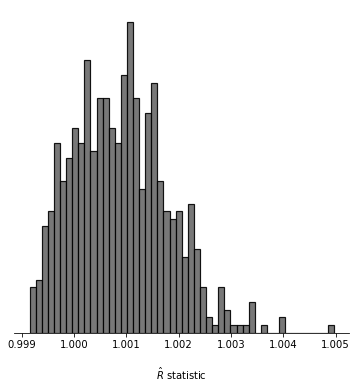

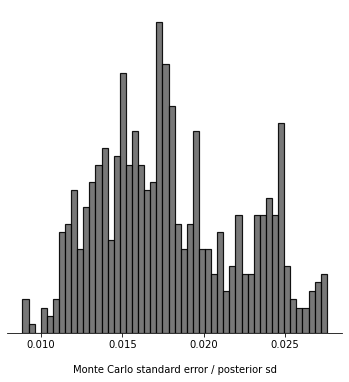

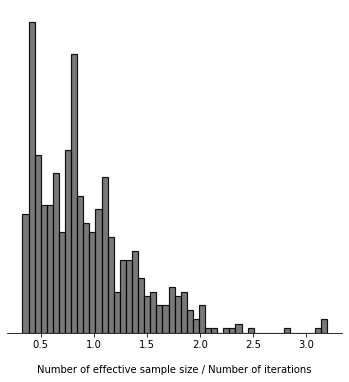

In [24]:
# Plot statistical summary of convergences
check_rhat(trace_hierar_p, threshold=1.005); #1.005 also considered
check_mcse(trace_hierar_p); 
check_neff(trace_hierar_p);


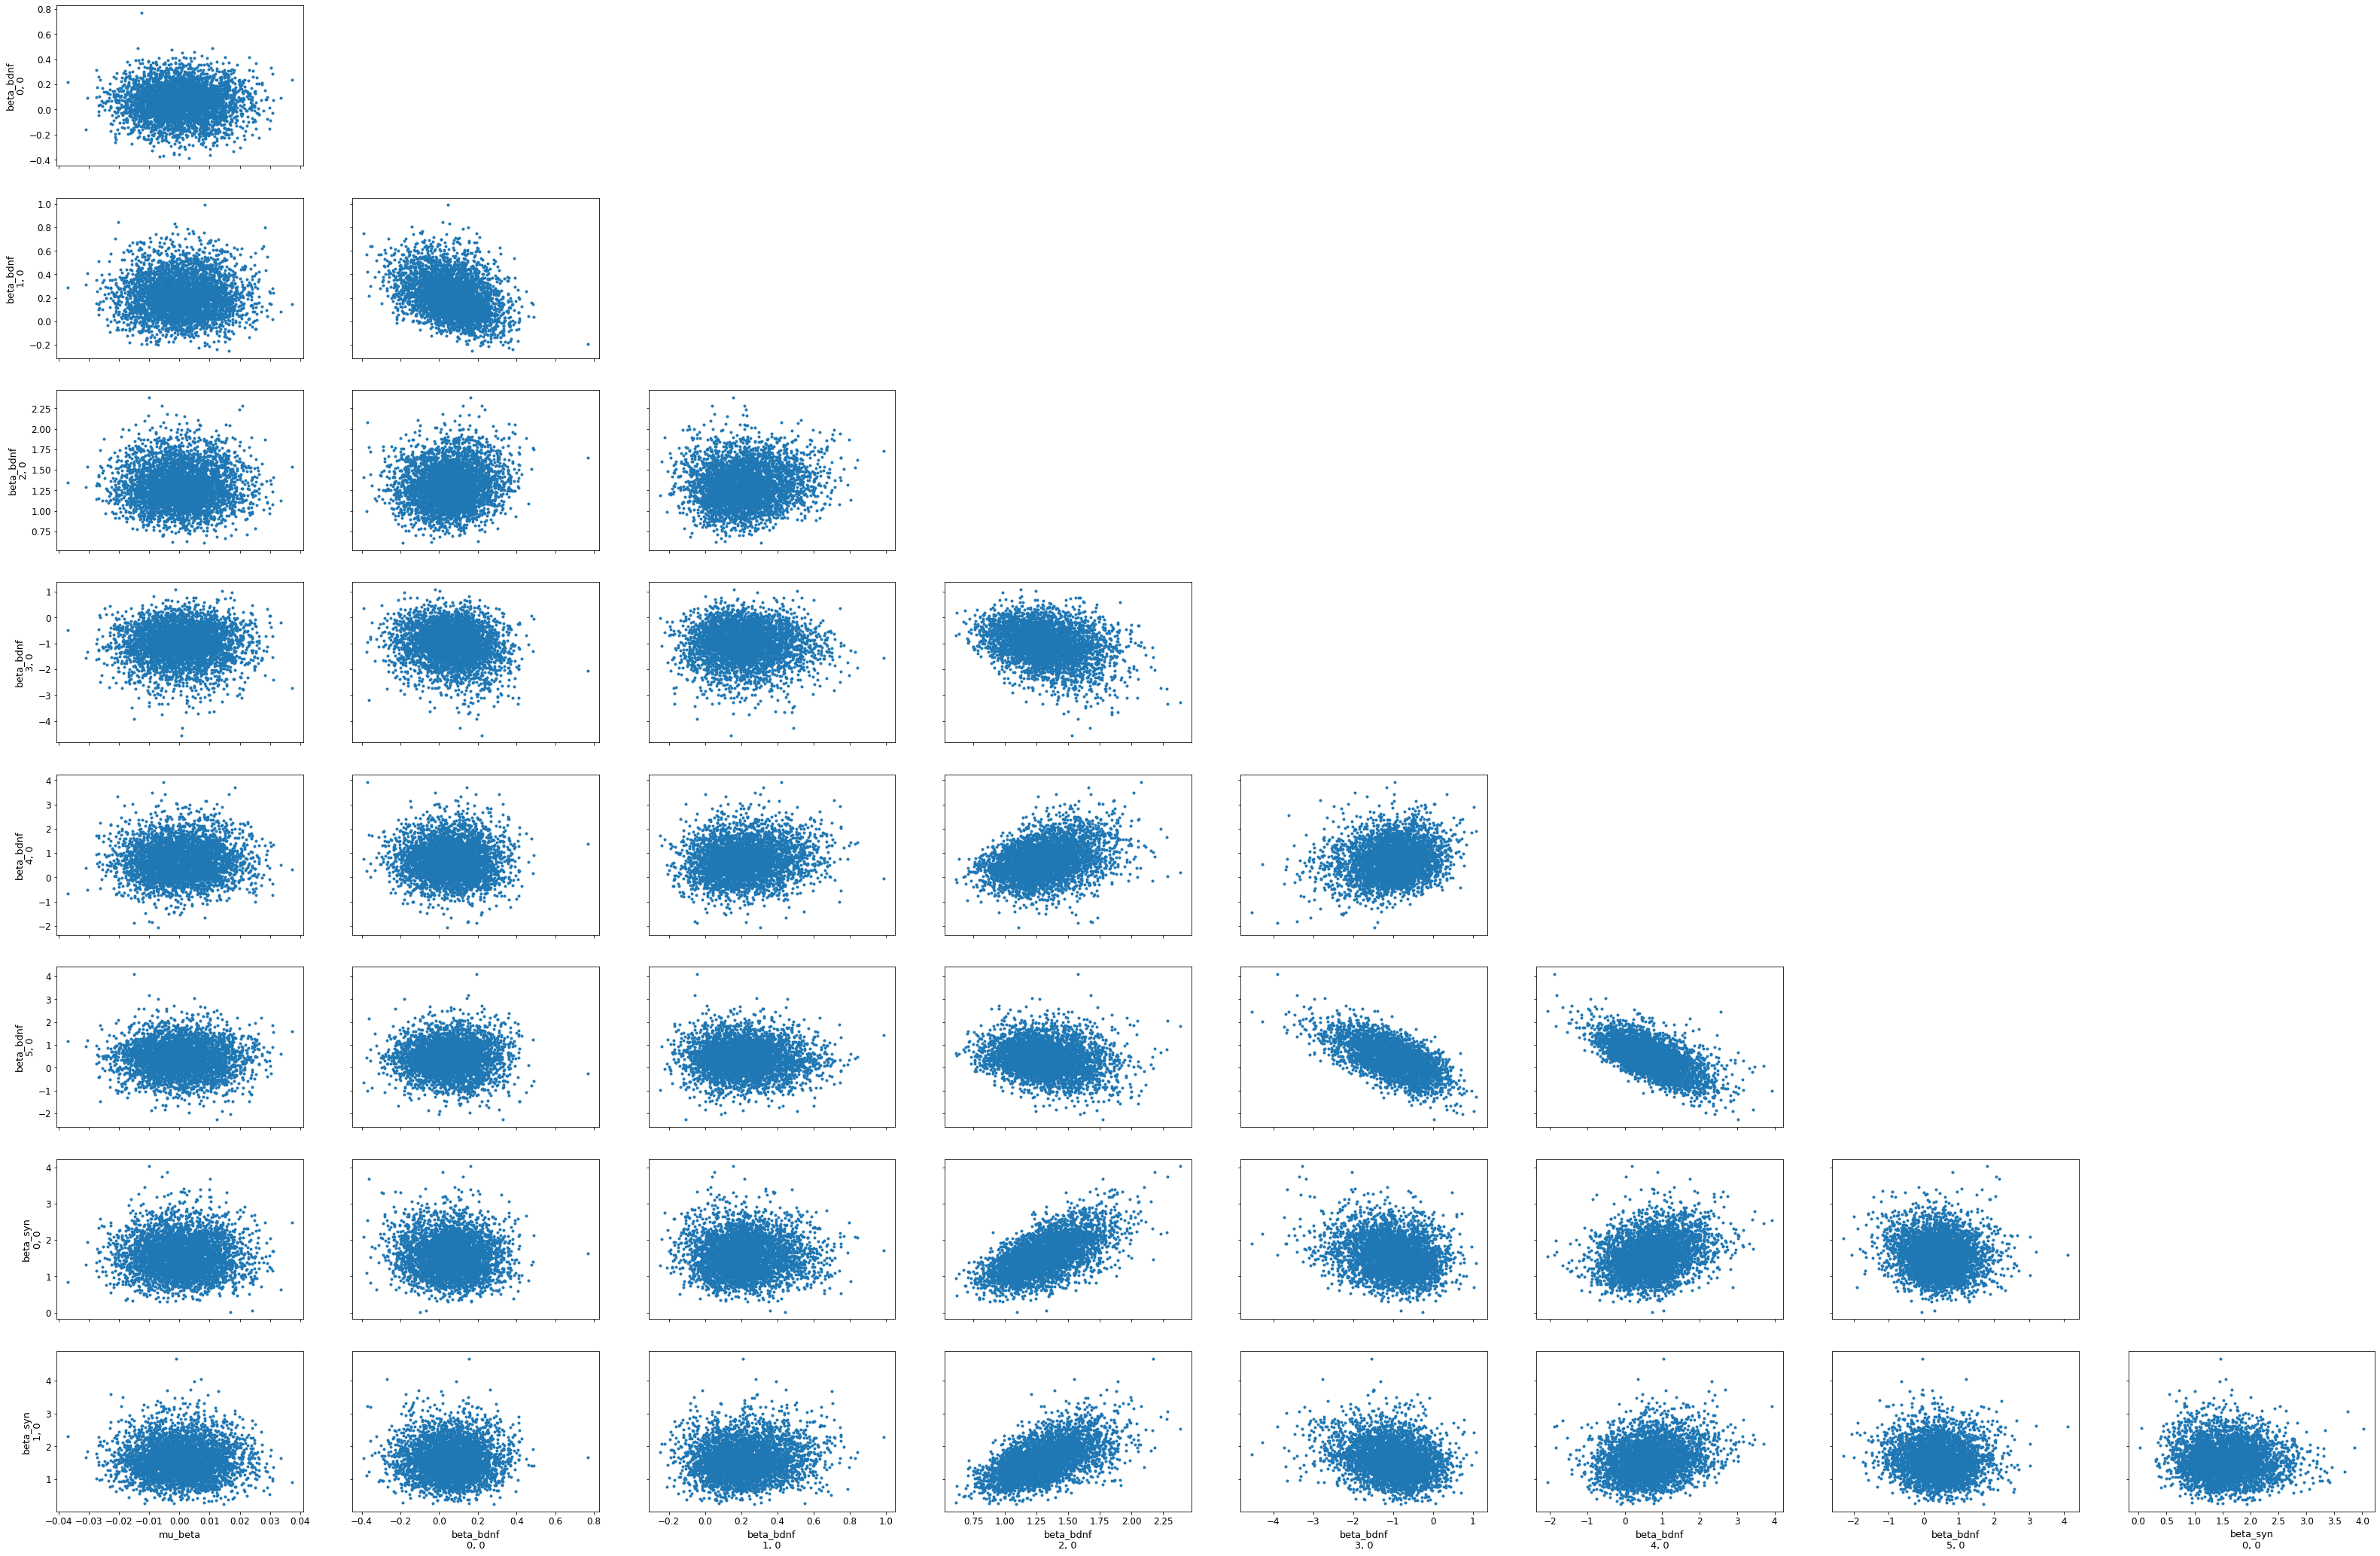

In [71]:
# ## Relationship for combination of variables
az.plot_pair(idata_hierar, textsize=12);

### Visualisations

In [65]:
# ## Define labels for plots
ylabels= data["Chemical"].astype(str) + " (" + data["CASRN"].astype(str) + ")"

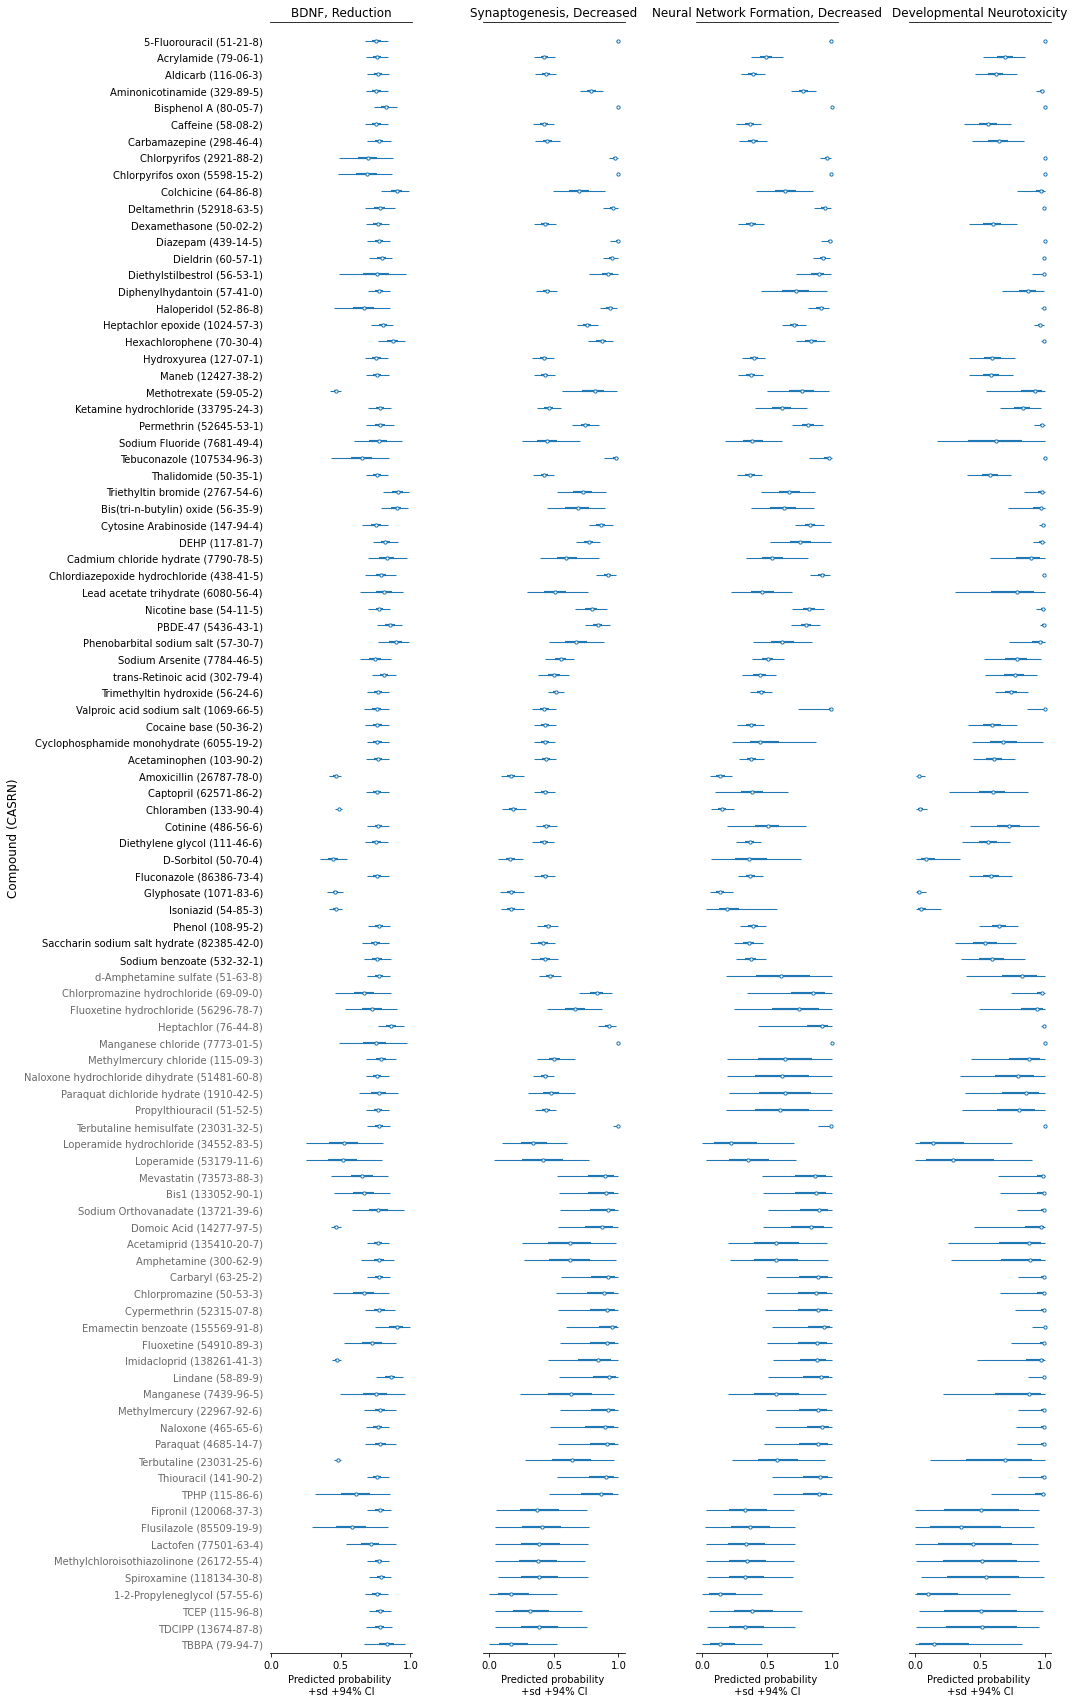

In [26]:
# ## Forestplots with underlying the compounds tested in both studies
fig, ax = plt.subplots(1, 4, figsize=(14,30), sharey=True)


ax0 = pm.forestplot(trace_hierar, 
                   var_names='lp_bdnf', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[0])
ax1 = pm.forestplot(trace_hierar, 
                   var_names='lp_syn', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[1])

ax2 = pm.forestplot(trace_hierar, 
                   var_names='lp_nnf', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[2])
ax3 = pm.forestplot(trace_hierar, 
                   var_names='lp_dnt', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[3])

ax[0].set_yticklabels(ylabels[::-1]) #weight = 'bold'

for ind in range(0,41):
    ax[0].get_yticklabels()[ind].set_color("dimgray") 

ax[0].set_xlim([-0.01,1.01])
ax[0].set_xlabel("Predicted probability \n+sd +94% CI")
ax[1].set_xlabel("Predicted probability \n+sd +94% CI")
ax[2].set_xlabel("Predicted probability \n+sd +94% CI")
ax[3].set_xlabel("Predicted probability \n+sd +94% CI")
ax[0].set_ylabel("Compound (CASRN)", fontsize=12)
ax[0].set_title("BDNF, Reduction", fontsize=12)
ax[1].set_title("Synaptogenesis, Decreased", fontsize=12)
ax[2].set_title("Neural Network Formation, Decreased", fontsize=12)
ax[3].set_title("Developmental Neurotoxicity", fontsize=12);

plt.subplots_adjust(wspace=0.5)
#plt.tight_layout();

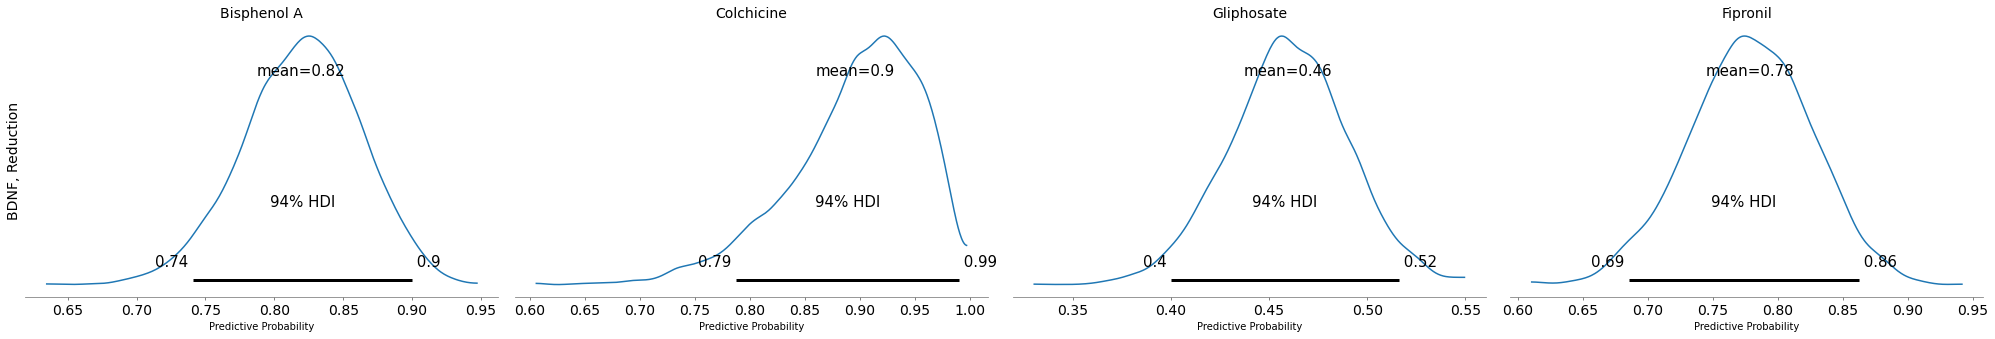

In [27]:
# ## Compare posteriors of three compounds: positive, negative and with missing data
# BDNF
ax = az.plot_posterior(trace_hierar, var_names='lp_bdnf', coords={'lp_bdnf_dim_0': [4, 9, 51, 88]}, 
                        transform=logistic)

ax[0].set_xlabel("Predictive Probability")
ax[1].set_xlabel("Predictive Probability")
ax[2].set_xlabel("Predictive Probability")
ax[3].set_xlabel("Predictive Probability")

ax[0].set_ylabel("BDNF, Reduction", fontsize=14)

ax[0].set_title("Bisphenol A", fontsize=14)
ax[1].set_title("Colchicine", fontsize=14);
ax[2].set_title("Gliphosate", fontsize=14)
ax[3].set_title("Fipronil", fontsize=14);

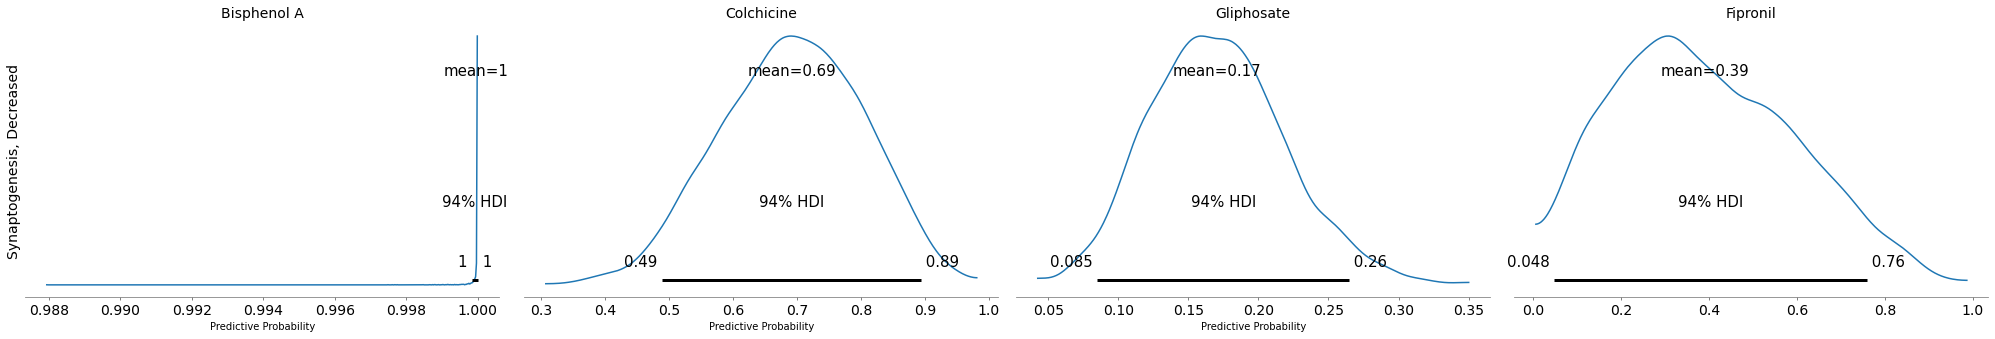

In [28]:
# SYN
ax = az.plot_posterior(trace_hierar, var_names='lp_syn', coords={'lp_syn_dim_0': [4, 9, 51, 88]}, 
                        transform=logistic)

ax[0].set_xlabel("Predictive Probability")
ax[1].set_xlabel("Predictive Probability")
ax[2].set_xlabel("Predictive Probability")

ax[0].set_ylabel("Synaptogenesis, Decreased", fontsize=14)

ax[0].set_title("Bisphenol A", fontsize=14)
ax[1].set_title("Colchicine", fontsize=14);
ax[2].set_title("Gliphosate", fontsize=14)
ax[3].set_title("Fipronil", fontsize=14);

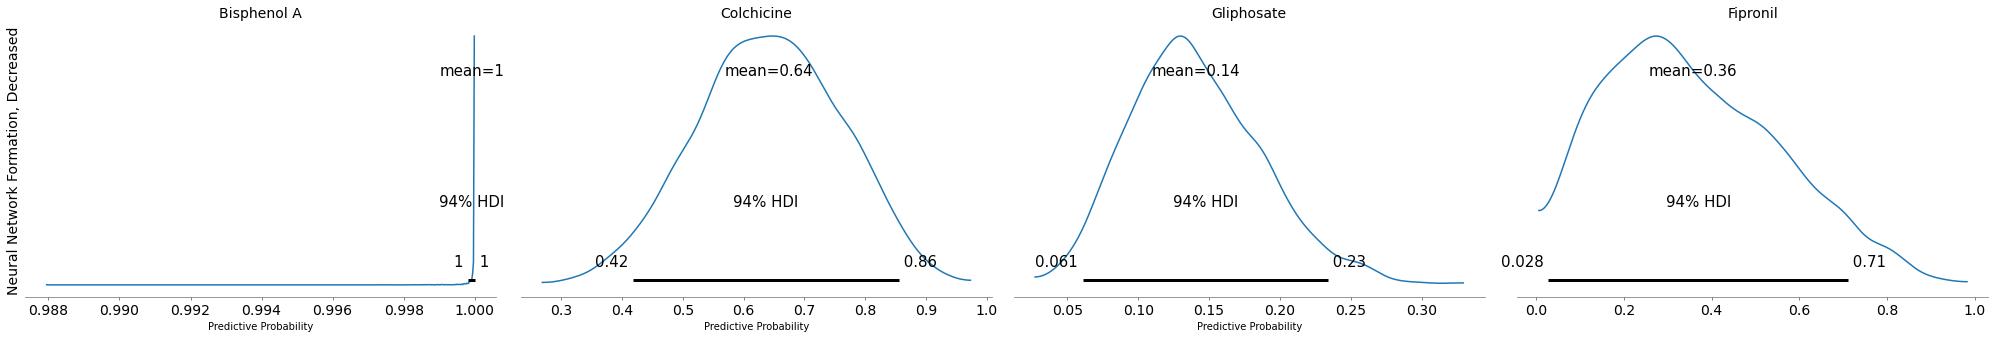

In [29]:
# NNF
ax = az.plot_posterior(trace_hierar, var_names='lp_nnf', coords={'lp_nnf_dim_0': [4, 9, 51, 88]}, 
                        transform=logistic)

ax[0].set_xlabel("Predictive Probability")
ax[1].set_xlabel("Predictive Probability")
ax[2].set_xlabel("Predictive Probability")

ax[0].set_ylabel("Neural Network Formation, Decreased", fontsize=14)

ax[0].set_title("Bisphenol A", fontsize=14)
ax[1].set_title("Colchicine", fontsize=14);
ax[2].set_title("Gliphosate", fontsize=14)
ax[3].set_title("Fipronil", fontsize=14);

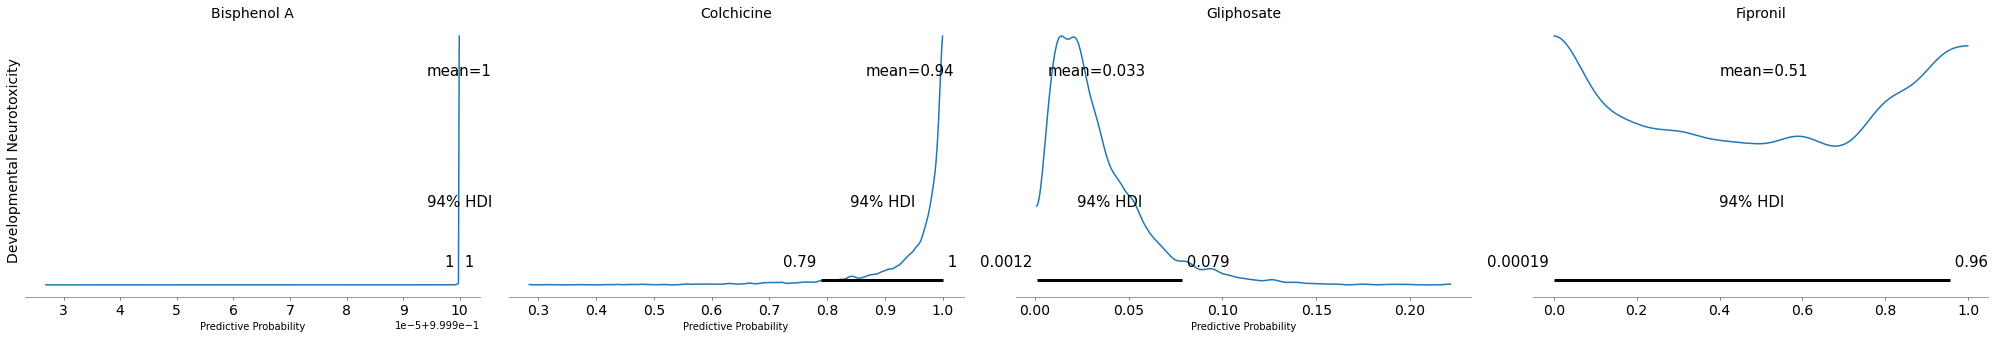

In [30]:
# DNT
ax = az.plot_posterior(trace_hierar, var_names='lp_dnt', coords={'lp_dnt_dim_0': [4, 9, 51, 88]},
                       transform=logistic)

ax[0].set_xlabel("Predictive Probability")
ax[1].set_xlabel("Predictive Probability")
ax[2].set_xlabel("Predictive Probability")

ax[0].set_ylabel("Developmental Neurotoxicity", fontsize=14)

ax[0].set_title("Bisphenol A", fontsize=14)
ax[1].set_title("Colchicine", fontsize=14);
ax[2].set_title("Gliphosate", fontsize=14)
ax[3].set_title("Fipronil", fontsize=14);

In [46]:
# ## Helper functions

def logistic(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# ## Ordered compounds for each key event based on mean and hdi


In [ ]:
#Version I
#ERROR Exception: Data must be 1-dimensional
lp_bdnf_mean = pd.Series(logistic(trace_hierar['lp_bdnf'].mean(axis=0)), index=ylabels)
lp_bdnf_se = pd.Series(logistic(trace_hierar['lp_bdnf'].std(axis=0)), index=ylabels)

In [ ]:
#Version II
#ERROR TypeError: 'InferenceData' object is not subscriptable
lp_bdnf_mean = idata_hierar.posterior['lp_bdnf'].mean(dim=("chain", "draw"))
lp_bdnf_hdi = az.hdi(idata_hierar['lp_bdnf'], var_names=["lp_bdnf"], hdi_prob=.95)

In [ ]:
#Version III
#ERROR TypeError: only size-1 arrays can be converted to Python scalars
lp_bdnf_mean = posterior_hierar['y_obs_dnt'].mean(axis=0)
lp_bdnf_std = posterior_hierar['y_obs_dnt'].std(axis=0)

In [ ]:
plt.scatter(range(len(lp_bdnf_mean)-1), lp_bdnf_mean[order])
for i, m, se in zip(range(len(lp_bdnf_mean)-1), lp_bdnf_mean[order],  lp_bdnf_std[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')

In [127]:
lp_bdnf_mean_sort = lp_bdnf_mean.sort()
lp_bdnf_std_sort = lp_bdnf_tsd.sel(data.index).sortby(lp_bdnf_mean_sort.y_obs_dnt)
lp_bdnf_mean_sort.plt.scatter(x="Chemical", y="y_obs_dnt")
ax.vlines(np.arange(ylabels),
         lp_bdnf_hdi_sort.y_obs_dnt.sel(hdi='lower'),
         lp_bdnf_hdi_sort.y_obs_dnt.sel(hdi='higher'))

TypeError: an integer is required (got type RangeIndex)

In [ ]:
# ## Risk assessment for developmental neurotoxicity
# Ordered compounds and colour-coded 0<0.33<0.66<1 for each key event



    if pred_dnt <=0.33:
        risk_col = 'green'
    elif pred_dnt <=0.66:
        risk_col = 'gold'
    elif pred_dnt >=0.66:
        risk_col = 'firebrick'


In [ ]:
# ## Distributions of log Probability between yes no and missing classes for each key event
_, ax = plt.subplots(1, 4, figsize=(5,7))




#Draw a line for 50%
ax[0].hlines(0.5, *ax[0].get_xlim(), color="black", ls = '--', linewidth=1)
ax[1].hlines(0.5, *ax[0].get_xlim(), color="black", ls = '--', linewidth=1)
ax[2].hlines(0.5, *ax[0].get_xlim(), color="black", ls = '--', linewidth=1)
ax[3].hlines(0.5, *ax[0].get_xlim(), color="black", ls = '--', linewidth=1)

#Set the labels
ax[0].set_title('BDNF, Reduction')
ax[1].set_title('Synaptogenesis, Decreased')
ax[2].set_title('Neural Network Formation, Decreased')
ax[3].set_title('Developmental Neurotixicity')

ax[0].set_ylabel('Predicted Probability')
ax[0].set_xlabel('Yes', 'No', 'Missing')

ax[1].set_ylabel('Predicted Probability')
ax[1].set_xlabel('Yes', 'No', 'Missing')

ax[2].set_ylabel('Predicted Probability')
ax[2].set_xlabel('Yes', 'No', 'Missing')

ax[3].set_ylabel('Predicted Probability')
ax[3].set_xlabel('Yes', 'No', 'Missing');

ax.tick_params(rotation=30)

plt.tight_layout();

### Strategy: Mean imputation

In [25]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#BDNF
X_bdnf_meanimpute = imp_mean.fit_transform(x_bdnf)
Y_bdnf_meanimpute = imp_mean.fit_transform(y_bdnf)

#Syn
X_syn_meanimpute = imp_mean.fit_transform(x_syn)

#NNF
X_nnf_meanimpute = imp_mean.fit_transform(x_nnf)

### Define and fit the model

In [26]:
with pm.Model() as model_meanimpute:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [27]:
# ## Define BDNF 
with model_meanimpute:
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_meanimpute, beta_bdnf)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_meanimpute)

In [28]:
# ## Define SYN
with model_meanimpute:   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_meanimpute, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p = lp_syn, observed=Y_syn)

In [29]:
# ## Define NNF
with model_meanimpute:
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_meanimpute, beta_nnf))
    y_obs_nnf = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=Y_nnf)

In [30]:
# ## Define DNT
with model_meanimpute:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

In [31]:
# Checking the proposed structure of model
model_meanimpute.check_test_point()

mu_beta           3.69
sd_beta_log__    -0.77
beta_bdnf       -13.82
beta_syn         -4.61
beta_nnf         -6.91
y_obs_bdnf      -67.24
y_obs_syn       -67.24
y_obs_nnf       -67.24
y_obs_dnt       -67.24
Name: Log-probability of test_point, dtype: float64

In [32]:
# Make the inferences
with model_meanimpute:
    trace_meanimpute = pm.sample(cores=4, target_accept=0.90) #return_inferencedata=True,

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [33]:
# ## Compute posterior distributions
with model_meanimpute:
    posterior_meanimpute = pm.sample_posterior_predictive(trace_meanimpute)

In [34]:
idata_meanimpute = az.from_pymc3(trace=trace_meanimpute, 
                             posterior_predictive=posterior_meanimpute,
                             model=model_meanimpute)
idata_meanimpute

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

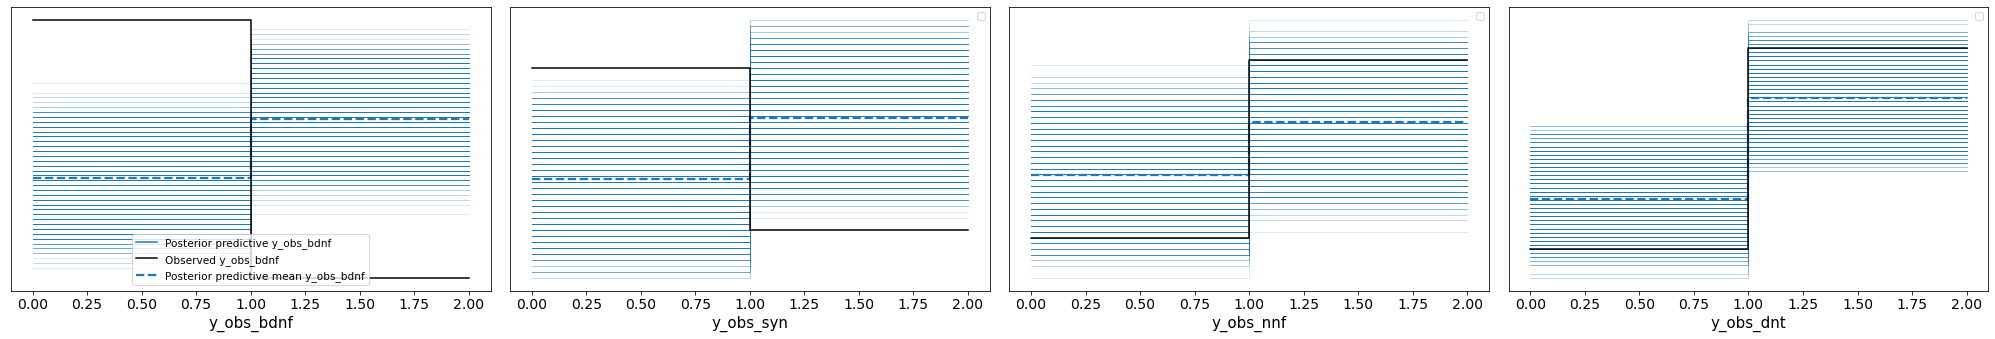

In [100]:
# ## Plot the posterior vs observed values
az.plot_ppc(idata_meanimpute);

The following parameters have an Rhat greater 1.005:
None



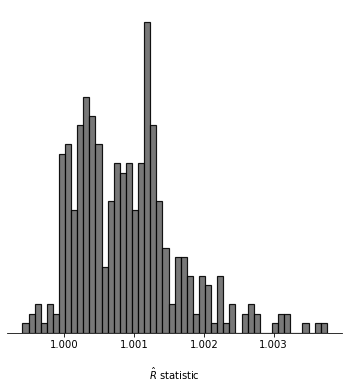

In [60]:
check_rhat(trace_meanimpute, threshold=1.005);

### MULTIVARIATE MODEL

### Strategy by distribution imputation

### Define and fit the model

In [36]:
with pm.Model() as model_mvn:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [37]:
# ## Define BDNF 
with model_mvn:
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sigma=1, 
                         shape=(X_bdnf_train.shape[-1] - 2, 1))
    _bdnf_raw = pm.Normal('_bdnf_raw', mu=0, sigma=1,
                          shape=(X_bdnf_train.shape[-1], X_bdnf_train.shape[0]))
    bdnf_chol, *_ = pm.LKJCholeskyCov(
        "bdnf_chol", 
        n=X_bdnf_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    Xmu_bdnf_ = tt.concatenate([tt.zeros([2, 1]), Xmu_bdnf], axis=0)
    bdnf_rotated = (Xmu_bdnf_ + tt.dot(bdnf_chol, _bdnf_raw)).T
    bdnf_predictor_continue = pm.Normal(
        'bdnf_predictor_continue',
        mu=bdnf_rotated[:, :2], sigma=.05,
        observed=X_bdnf_train[:, :2])
    bdnf_predictor_binary = pm.Bernoulli(
        'bdnf_predictor_binary',
        logit_p=bdnf_rotated[:, 2:],
        observed=X_bdnf_train[:, 2:])
    
    X_bdnf_modelled = tt.concatenate(
        [bdnf_predictor_continue, bdnf_predictor_binary],
        axis=-1
    )

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', tt.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [38]:
# ## Define SYN
with model_mvn:
    # Imputation of X missing values for Syn
    syn_chol, *_ = pm.LKJCholeskyCov(
        "syn_chol", 
        n=X_syn_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_syn_modelled = pm.MvNormal(
        'X_syn_modelled',
        mu=0., chol=syn_chol,
        observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn_train)

In [39]:
# ## Define NNF
with model_mvn:
    # Imputation of X missing values for NNF
    nnf_chol, *_ = pm.LKJCholeskyCov(
        "nnf_chol", 
        n=X_nnf_train.shape[-1], eta=.5, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_nnf_modelled = pm.MvNormal(
        'X_nnf_modelled',
        mu=0., chol=nnf_chol,
        observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + tt.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [40]:
# ## Define DNT
with model_mvn:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [41]:
# ## Checking the proposed structure of model
model_mvn.check_test_point()

mu_beta                                3.69
sd_beta_log__                         -0.77
beta_bdnf                            -13.82
beta_syn                              -4.61
beta_nnf                              -6.91
Xmu_bdnf                              -3.68
_bdnf_raw                           -534.82
bdnf_chol_cholesky-cov-packed__       -0.92
bdnf_predictor_continue_missing        0.00
bdnf_predictor_binary_missing          0.00
y_obs_bdnf_missing                     0.00
syn_chol_cholesky-cov-packed__        -0.76
X_syn_modelled_missing                 0.00
y_obs_syn_missing                      0.00
nnf_chol_cholesky-cov-packed__         0.35
X_nnf_modelled_missing                 0.00
y_obs_nnf_missing                      0.00
bdnf_predictor_continue           -35997.10
bdnf_predictor_binary               -268.94
y_obs_bdnf                           -67.24
X_syn_modelled                      -245.27
y_obs_syn                            -67.24
X_nnf_modelled                  

In [42]:
# ## Make the inferences
with model_mvn:
    trace_mvn = pm.sample(cores=4, nuts ={'target_accept':0.90}) #return_inferencedata=True,

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, nnf_chol, X_syn_modelled_missing, syn_chol, bdnf_predictor_continue_missing, bdnf_chol, _bdnf_raw, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [bdnf_predictor_binary_missing, y_obs_bdnf_missing, y_obs_syn_missing, y_obs_nnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 501 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [41]:
# ## Convert in Arviz
idata_mvn = az.from_pymc3(trace=trace_mvn, 
                             model=model_mvn)
idata_mvn

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

The following parameters have an Rhat greater 1.005:
['_bdnf_raw[0,0]', '_bdnf_raw[0,1]', '_bdnf_raw[0,2]', '_bdnf_raw[0,3]', '_bdnf_raw[0,4]', '_bdnf_raw[0,5]', '_bdnf_raw[0,6]', '_bdnf_raw[0,7]', '_bdnf_raw[0,8]', '_bdnf_raw[0,9]', '_bdnf_raw[0,10]', '_bdnf_raw[0,12]', '_bdnf_raw[0,13]', '_bdnf_raw[0,14]', '_bdnf_raw[0,16]', '_bdnf_raw[0,17]', '_bdnf_raw[0,18]', '_bdnf_raw[0,19]', '_bdnf_raw[0,20]', '_bdnf_raw[0,21]', '_bdnf_raw[0,22]', '_bdnf_raw[0,23]', '_bdnf_raw[0,24]', '_bdnf_raw[0,25]', '_bdnf_raw[0,26]', '_bdnf_raw[0,27]', '_bdnf_raw[0,28]', '_bdnf_raw[0,29]', '_bdnf_raw[0,30]', '_bdnf_raw[0,32]', '_bdnf_raw[0,33]', '_bdnf_raw[0,35]', '_bdnf_raw[0,36]', '_bdnf_raw[0,37]', '_bdnf_raw[0,38]', '_bdnf_raw[0,39]', '_bdnf_raw[0,40]', '_bdnf_raw[0,42]', '_bdnf_raw[0,43]', '_bdnf_raw[0,44]', '_bdnf_raw[0,45]', '_bdnf_raw[0,47]', '_bdnf_raw[0,48]', '_bdnf_raw[0,49]', '_bdnf_raw[0,50]', '_bdnf_raw[0,51]', '_bdnf_raw[0,52]', '_bdnf_raw[0,54]', '_bdnf_raw[0,55]', '_bdnf_raw[0,56]', '_bdnf

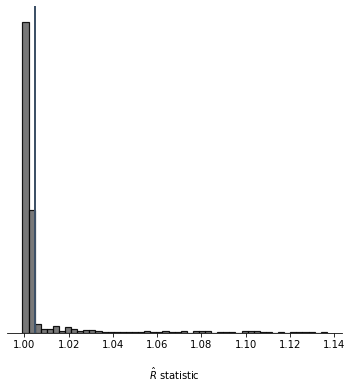

In [61]:
check_rhat(trace_mvn, threshold=1.005);

### Strategy: Mean imputation

### Define and fit the model

In [43]:
with pm.Model() as model_mvn_meanimpute:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [44]:
with model_mvn_meanimpute:
    #LKJ prior for covariance matrix    
    bdnf_chol, corr, stds = pm.LKJCholeskyCov(
        'bdnf_chol', n=6, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False)
    
    mu_bdnf = pm.Normal('mu_bdnf', mu=0, sd=1, shape=6)
    y_bdnf = pm.MvNormal('y_bdnf', mu=mu_bdnf, chol=bdnf_chol, observed=X_bdnf_meanimpute)
    
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf =  pm.Deterministic('lp_bdnf', tt.dot(y_bdnf, beta_bdnf))    
    y_obs_bdnf = pm.Bernoulli("y_obs_bdnf", logit_p=lp_bdnf, observed=Y_bdnf_meanimpute)

In [45]:
with model_mvn_meanimpute:
    #LKJ prior for covariance matrix    
    syn_chol, corr, stds = pm.LKJCholeskyCov(
        'syn_chol', n=2, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_syn = pm.Normal('mu_syn', mu=0, sd=1, shape=2)
    y_syn = pm.MvNormal('y_syn', mu=mu_syn, chol=syn_chol, observed=X_syn_meanimpute)
    
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(y_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p=lp_syn, observed=Y_syn)

In [46]:
with model_mvn_meanimpute:
    #LKJ prior for covariance matrix    
    nnf_chol, corr, stds = pm.LKJCholeskyCov(
        'nnf_chol', n=3, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_nnf = pm.Normal('mu_nnf', mu=0, sd=1, shape=3)
    y_nnf = pm.MvNormal('y_nnf', mu=mu_nnf, chol=nnf_chol, observed=X_nnf_meanimpute)
    
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf =  pm.Deterministic('lp_nnf', lp_syn + tt.dot(y_nnf, beta_nnf))    
    y_obs_syn = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=Y_nnf)

In [47]:
with model_mvn_meanimpute:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

In [48]:
# Checking the proposed structure of model
model_mvn_meanimpute.check_test_point()

mu_beta                              3.69
sd_beta_log__                       -0.77
beta_bdnf                          -13.82
beta_syn                            -4.61
beta_nnf                            -6.91
bdnf_chol_cholesky-cov-packed__     -0.92
mu_bdnf                             -5.51
syn_chol_cholesky-cov-packed__      -0.76
mu_syn                              -1.84
nnf_chol_cholesky-cov-packed__      -0.58
mu_nnf                              -2.76
y_bdnf                            -686.02
y_obs_bdnf                         -67.24
y_syn                             -245.27
y_obs_syn                          -67.24
y_nnf                             -392.91
y_obs_nnf                          -67.24
y_obs_dnt                          -67.24
Name: Log-probability of test_point, dtype: float64

In [49]:
# Run inferences
with model_mvn_meanimpute:
    trace_mvn_meanimpute = pm.sample(cores=4, target_accept=0.90) #return_inferencedata=True,

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_nnf, nnf_chol, mu_syn, syn_chol, mu_bdnf, bdnf_chol, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.


The following parameters have an Rhat greater 1.005:
None



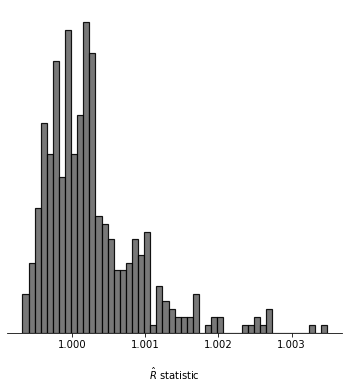

In [62]:
check_rhat(trace_mvn_meanimpute, threshold=1.005);

In [53]:
# ## Convert in Arviz
idata_mvn_meanimpute = az.from_pymc3(trace=trace_mvn_meanimpute, 
                             model=model_mvn_meanimpute)
idata_mvn_meanimpute

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### MODEL COMPARISON

### Comparison of predictors

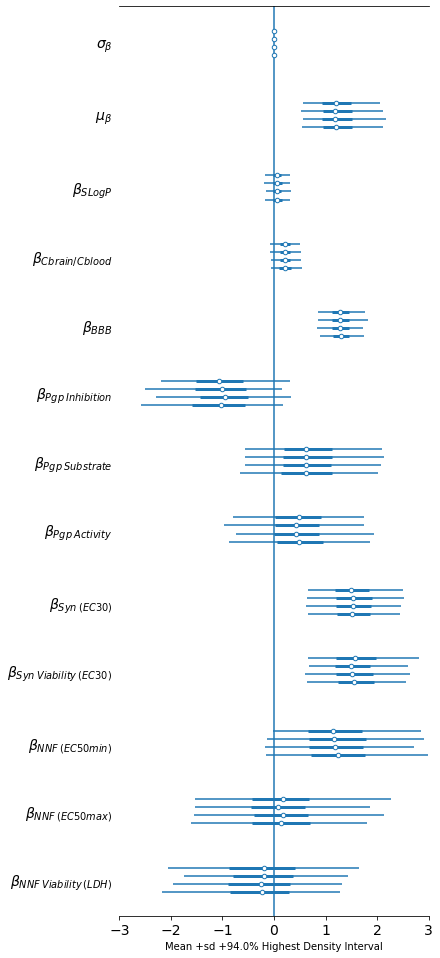

In [39]:
# For manuscript
# Plot parameters for model_hierar
ax = pm.forestplot(trace_hierar, var_names=['mu_beta', 'sd_beta','beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());
ax[0].set_xlim([-3,3]);
ax[0].set_yticklabels((r'$\beta_{NNF\:Viability\:(LDH)}$', 
                       r'$\beta_{NNF\:(EC50max)}$', r'$\beta_{NNF\:(EC50min)}$', r'$\beta_{Syn\:Viability\:(EC30)}$', 
                       r'$\beta_{Syn\:(EC30)}$', r'$\beta_{Pgp\: Activity}$', r'$\beta_{Pgp\: Substrate}$', 
                       r'$\beta_{Pgp\: Inhibition}$', r'$\beta_{BBB}$', r'$\beta_{Cbrain/Cblood}$', 
                       r'$\beta_{SLogP}$', r'$\mu_{\beta}$', r'$\sigma_{\beta}$'));
#ax[0].set_title('94.0% Highest Density Interval of Regression Model based on Distribution Imputation');
ax[0].set_xlabel('Mean +sd +94.0% Highest Density Interval');
ax[0].set_title("");
#Four lines per each beta because we run four chains

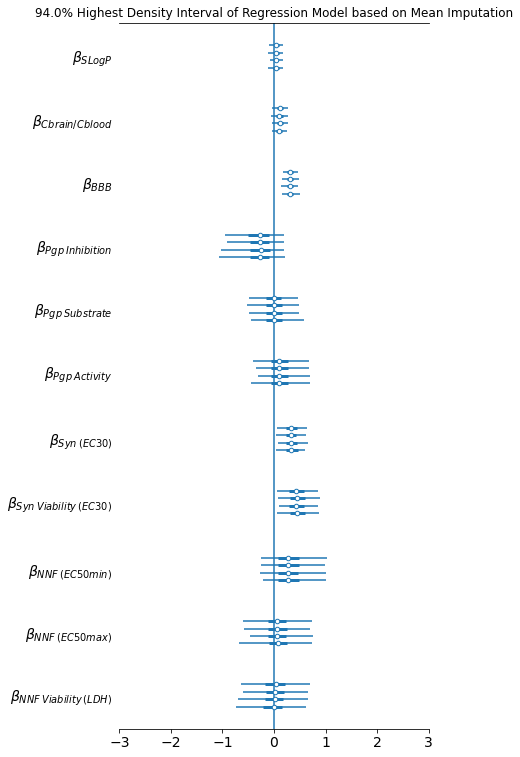

In [49]:
# Plot parameters for model_meanimpute
ax = pm.forestplot(trace_meanimpute, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());
ax[0].set_xlim([-3,3]);
ax[0].set_yticklabels((r'$\beta_{NNF\:Viability\:(LDH)}$', 
                       r'$\beta_{NNF\:(EC50max)}$', r'$\beta_{NNF\:(EC50min)}$', r'$\beta_{Syn\:Viability\:(EC30)}$', 
                       r'$\beta_{Syn\:(EC30)}$', r'$\beta_{Pgp\: Activity}$', r'$\beta_{Pgp\: Substrate}$', 
                       r'$\beta_{Pgp\: Inhibition}$', r'$\beta_{BBB}$', r'$\beta_{Cbrain/Cblood}$', 
                       r'$\beta_{SLogP}$'));
ax[0].set_title('94.0% Highest Density Interval of Regression Model based on Mean Imputation');

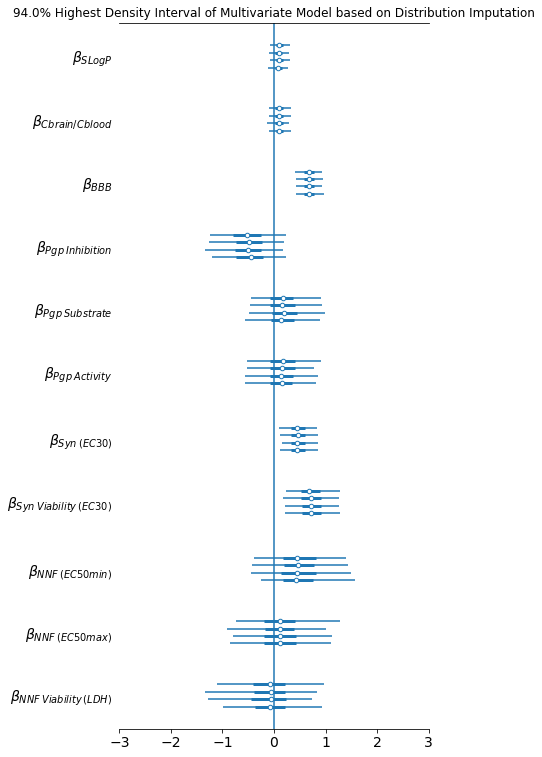

In [50]:
# Plot parameters for model_mvn
ax = pm.forestplot(trace_mvn, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());
ax[0].set_xlim([-3,3]);
ax[0].set_yticklabels((r'$\beta_{NNF\:Viability\:(LDH)}$', 
                       r'$\beta_{NNF\:(EC50max)}$', r'$\beta_{NNF\:(EC50min)}$', r'$\beta_{Syn\:Viability\:(EC30)}$', 
                       r'$\beta_{Syn\:(EC30)}$', r'$\beta_{Pgp\: Activity}$', r'$\beta_{Pgp\: Substrate}$', 
                       r'$\beta_{Pgp\: Inhibition}$', r'$\beta_{BBB}$', r'$\beta_{Cbrain/Cblood}$', 
                       r'$\beta_{SLogP}$'));
ax[0].set_title('94.0% Highest Density Interval of Multivariate Model based on Distribution Imputation');

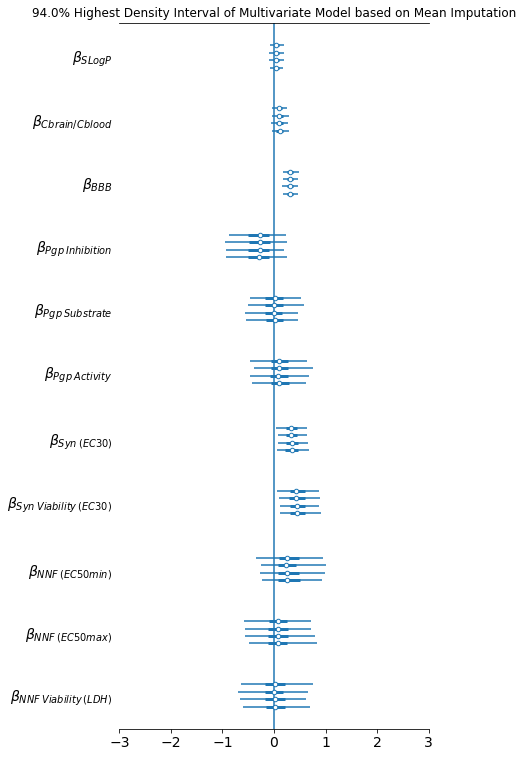

In [51]:
# Plot parameters for model_mvn_meanimpute
ax = pm.forestplot(trace_mvn_meanimpute, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());
ax[0].set_xlim([-3,3]);
ax[0].set_yticklabels((r'$\beta_{NNF\:Viability\:(LDH)}$', 
                       r'$\beta_{NNF\:(EC50max)}$', r'$\beta_{NNF\:(EC50min)}$', r'$\beta_{Syn\:Viability\:(EC30)}$', 
                       r'$\beta_{Syn\:(EC30)}$', r'$\beta_{Pgp\: Activity}$', r'$\beta_{Pgp\: Substrate}$', 
                       r'$\beta_{Pgp\: Inhibition}$', r'$\beta_{BBB}$', r'$\beta_{Cbrain/Cblood}$', 
                       r'$\beta_{SLogP}$'));
ax[0].set_title('94.0% Highest Density Interval of Multivariate Model based on Mean Imputation');

### Comparison of Predictive Performance

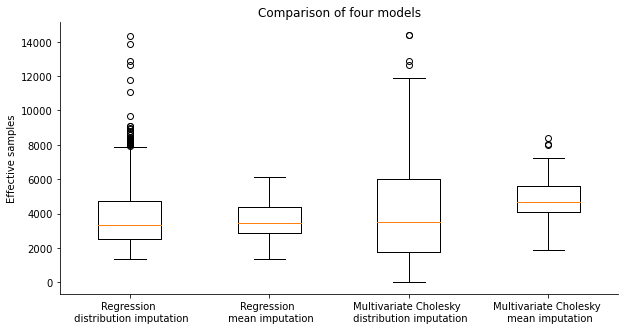

In [63]:
# ## Effective samples
# extract n_eff values for each model
neff_hierar = az.summary(trace_hierar)['ess_bulk'].values
neff_meanimpute = az.summary(trace_meanimpute)['ess_bulk'].values
neff_mvn = az.summary(trace_mvn)['ess_bulk'].values
neff_mvn_meanimpute = az.summary(trace_mvn_meanimpute)['ess_bulk'].values
# plot distributions
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.boxplot([neff_c, neff_nc, neff_mvn, neff_mvn_meanimpute], labels=["Regression \n distribution imputation", 
                                      "Regression \n mean imputation",
                                     "Multivariate Cholesky \n distribution imputation", 
                                     "Multivariate Cholesky \n mean imputation"]);
#ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Effective samples');
ax.set_title('Comparison of four models')
sns.despine(right=True, top = True)

In [ ]:
# ##LOO and WAIC
#Is there a way to select only lp and not all variables?

comp_df = az.compare({'model_hierar':trace_hierar,
                      'model_meanimpute':trace_meanimpute})

comp_df

### Watanabe - Akaike Information Criterion [WAIC]

#### BDNF

In [63]:
model_hierar_waic = az.waic(idata_hierar, var_name='y_obs_bdnf')
model_hierar_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

In [68]:
model_meanimpute_waic = az.waic(idata_meanimpute, var_name='y_obs_bdnf')
model_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -74.48     1.46
p_waic        0.67        -

In [69]:
model_mvn_waic = az.waic(idata_mvn, var_name='y_obs_bdnf')
model_mvn_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

In [70]:
model_mvn_meanimpute_waic = az.waic(idata_mvn_meanimpute, var_name='y_obs_bdnf')
model_mvn_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -74.63     1.49
p_waic        0.68        -

#### SYN

In [71]:
model_hierar_waic = az.waic(idata_hierar, var_name='y_obs_syn')
model_hierar_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -64.38     3.42
p_waic        6.12        -

In [72]:
model_meanimpute_waic = az.waic(idata_meanimpute, var_name='y_obs_syn')
model_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -62.17     1.88
p_waic        0.59        -

In [73]:
model_mvn_waic = az.waic(idata_mvn, var_name='y_obs_syn')
model_mvn_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -65.96     3.42
p_waic        6.18        -

In [74]:
model_mvn_meanimpute_waic = az.waic(idata_mvn_meanimpute, var_name='y_obs_syn')
model_mvn_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -62.14     1.91
p_waic        0.60        -

#### NNF

In [75]:
model_hierar_waic = az.waic(idata_hierar, var_name='y_obs_nnf')
model_hierar_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -63.99     4.29
p_waic        8.26        -

There has been a warning during the calculation. Please check the results.

In [76]:
model_meanimpute_waic = az.waic(idata_meanimpute, var_name='y_obs_nnf')
model_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -62.46     2.75
p_waic        1.48        -

There has been a warning during the calculation. Please check the results.

In [77]:
model_mvn_waic = az.waic(idata_mvn, var_name='y_obs_nnf')
model_mvn_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -63.69     4.12
p_waic        6.60        -

There has been a warning during the calculation. Please check the results.

In [78]:
model_mvn_meanimpute_waic = az.waic(idata_mvn_meanimpute, var_name='y_obs_nnf')
model_mvn_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -62.45     2.82
p_waic        1.54        -

There has been a warning during the calculation. Please check the results.

#### DNT

In [79]:
model_hierar_waic = az.waic(idata_hierar, var_name='y_obs_dnt')
model_hierar_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -45.33     3.70
p_waic       11.43        -

There has been a warning during the calculation. Please check the results.

In [80]:
model_meanimpute_waic = az.waic(idata_meanimpute, var_name='y_obs_dnt')
model_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -53.44     3.30
p_waic        2.93        -

In [81]:
model_mvn_waic = az.waic(idata_mvn, var_name='y_obs_dnt')
model_mvn_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -45.23     3.66
p_waic       10.79        -

There has been a warning during the calculation. Please check the results.

In [82]:
model_mvn_meanimpute_waic = az.waic(idata_mvn_meanimpute, var_name='y_obs_dnt')
model_mvn_meanimpute_waic

Computed from 4000 by 97 log-likelihood matrix

          Estimate       SE
elpd_waic   -53.32     3.34
p_waic        2.96        -

### Leave-one-out Cross-Validation [LOO]

#### BDNF

In [83]:
model_hierar_loo = az.loo(idata_hierar, var_name='y_obs_bdnf')
model_hierar_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo      nan      nan
p_loo         nan        -

There has been a warning during the calculation. Please check the results.

In [84]:
model_meanimpute_loo = az.loo(idata_meanimpute, var_name='y_obs_bdnf')
model_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -74.48     1.46
p_loo        0.67        -

In [85]:
model_mvn_loo = az.loo(idata_mvn, var_name='y_obs_bdnf')
model_mvn_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo      nan      nan
p_loo         nan        -

There has been a warning during the calculation. Please check the results.

In [86]:
model_mvn_meanimpute_loo = az.loo(idata_mvn_meanimpute, var_name='y_obs_bdnf')
model_mvn_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -74.63     1.49
p_loo        0.68        -

#### SYN

In [87]:
model_hierar_loo = az.loo(idata_hierar, var_name='y_obs_syn')
model_hierar_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -64.58     3.46
p_loo        6.33        -

In [88]:
model_meanimpute_loo = az.loo(idata_meanimpute, var_name='y_obs_syn')
model_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.17     1.88
p_loo        0.59        -

In [89]:
model_mvn_loo = az.loo(idata_mvn, var_name='y_obs_syn')
model_mvn_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -66.18     3.46
p_loo        6.40        -

In [90]:
model_mvn_meanimpute_loo = az.loo(idata_mvn_meanimpute, var_name='y_obs_syn')
model_mvn_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.14     1.91
p_loo        0.60        -

#### NNF

In [91]:
model_hierar_loo = az.loo(idata_hierar, var_name='y_obs_nnf')
model_hierar_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -64.24     4.33
p_loo        8.51        -

In [92]:
model_meanimpute_loo = az.loo(idata_meanimpute, var_name='y_obs_nnf')
model_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.50     2.75
p_loo        1.52        -

In [93]:
model_mvn_loo = az.loo(idata_mvn, var_name='y_obs_nnf')
model_mvn_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -63.91     4.17
p_loo        6.81        -

In [94]:
model_mvn_meanimpute_loo = az.loo(idata_mvn_meanimpute, var_name='y_obs_nnf')
model_mvn_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.49     2.82
p_loo        1.58        -

#### DNT

In [95]:
model_hierar_loo = az.loo(idata_hierar, var_name='y_obs_dnt')
model_hierar_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -46.63     3.86
p_loo       12.73        -

In [96]:
model_meanimpute_loo = az.loo(idata_meanimpute, var_name='y_obs_dnt')
model_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -53.49     3.30
p_loo        2.98        -

In [97]:
model_mvn_loo = az.loo(idata_mvn, var_name='y_obs_dnt')
model_mvn_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -46.38     3.80
p_loo       11.95        -

There has been a warning during the calculation. Please check the results.

In [98]:
model_mvn_meanimpute_loo = az.loo(idata_mvn_meanimpute, var_name='y_obs_dnt')
model_mvn_meanimpute_loo

Computed from 4000 by 97 log-likelihood matrix

         Estimate       SE
elpd_loo   -53.37     3.34
p_loo        3.01        -

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz   0.10.0
numpy   1.19.1
pandas  1.1.1
pymc3   3.9.3
theano  1.0.4
seaborn 0.11.0
last updated: Sat Oct 03 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
